In [52]:
import warnings
warnings.filterwarnings("ignore")

import wandb
wandb.login(key="93b4881869bab13360839595daa56e51dd0405df")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [55]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
# PyTorch Lightning imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data_dir = "inaturalist_12K"

Using device: cuda


In [56]:
class CNNModel(pl.LightningModule):
    def __init__(self,
                 input_channels=3,  # RGB images
                 num_classes=10,
                 filters=[32, 64, 128, 256, 512],  # Number of filters in each conv layer
                 filter_size=3,     # Size of filters (k×k)
                 activation='relu', # Activation function
                 dense_neurons=512, # Number of neurons in dense layer
                 dropout_rate=0.5,  # Dropout rate
                 use_batchnorm=True, # Whether to use batch normalization
                 learning_rate=0.001,
                 weight_decay=0.0001,
                 optimizer='adam',
                 lr_decay_factor=0.1,
                 lr_patience=3
                ):
        super(CNNModel, self).__init__()
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Set activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'mish':
            self.activation = nn.Mish()
        else:
            self.activation = nn.ReLU()  # Default to ReLU

        # Create convolution blocks
        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels

        for i, out_channels in enumerate(filters):
            block = nn.Sequential()

            # Convolution layer
            block.add_module(f"conv{i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2))

            # Batch normalization (optional)
            if use_batchnorm:
                block.add_module(f"batchnorm{i+1}", nn.BatchNorm2d(out_channels))

            # Activation function
            block.add_module(f"activation{i+1}", self.activation)

            # Max pooling
            block.add_module(f"maxpool{i+1}", nn.MaxPool2d(kernel_size=2, stride=2))

            # Add dropout after each block except the last one
            if i < len(filters) - 1 and dropout_rate > 0:
                block.add_module(f"dropout{i+1}", nn.Dropout(dropout_rate))

            self.conv_blocks.append(block)
            in_channels = out_channels

        # Calculate output size of last conv layer
        # Assuming input image size is 256×256
        output_size = 256 // (2 ** len(filters))  # Due to max pooling with stride 2
        flattened_size = filters[-1] * output_size * output_size

        # Dense layers
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(flattened_size, dense_neurons)
        self.dense_activation = self.activation
        self.dense_dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(dense_neurons, num_classes)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Pass through convolution blocks
        for block in self.conv_blocks:
            x = block(x)

        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense_activation(x)
        x = self.dense_dropout(x)
        x = self.output(x)

        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def on_test_epoch_start(self):
        self.test_step_outputs = []
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        
        # Save output for later use
        output = {'test_loss': loss, 'test_acc': acc, 'preds': preds, 'targets': y}
        self.test_step_outputs.append(output)
        
        return output
    
    def on_test_epoch_end(self):
    # Get outputs from the test_step
        outputs = self.test_step_outputs  # This will work if you collect outputs during test_step
        
        # Concatenate all predictions and targets for confusion matrix
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_targets = torch.cat([x['targets'] for x in outputs])
        
        self.test_predictions = all_preds
        self.test_targets = all_targets
    
    def configure_optimizers(self):
        # Set up optimizer based on configuration
        if self.hparams.optimizer == 'adam':
            optimizer = optim.Adam(
                self.parameters(), 
                lr=self.hparams.learning_rate, 
                weight_decay=self.hparams.weight_decay
            )
        elif self.hparams.optimizer == 'sgd':
            optimizer = optim.SGD(
                self.parameters(), 
                lr=self.hparams.learning_rate, 
                momentum=0.9, 
                weight_decay=self.hparams.weight_decay
            )
        else:
            optimizer = optim.Adam(
                self.parameters(), 
                lr=self.hparams.learning_rate, 
                weight_decay=self.hparams.weight_decay
            )
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.hparams.lr_decay_factor,
            patience=self.hparams.lr_patience,
            verbose=True
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch'
            }
        }
    
    def calculate_num_params(self):
        """Calculate the total number of parameters in the model"""
        return sum(p.numel() for p in self.parameters())

In [57]:
def calculate_model_stats(model, input_size=(3, 256, 256)):
    """Calculate number of parameters and FLOPs for a model"""
    try:
        from torchsummary import summary
        
        # Print model summary
        print("Model Summary:")
        summary(model.to(device), input_size=input_size)
    except ImportError:
        print("torchsummary not available, printing basic model info:")
        print(model)

    # Calculate total parameters
    total_params = model.calculate_num_params()
    print(f"\nTotal parameters: {total_params:,}")

# Let's create a sample model to analyze
sample_model = CNNModel(
    input_channels=3,
    num_classes=10,
    filters=[32, 64, 128, 256, 512],
    filter_size=3,
    activation='relu',
    dense_neurons=512,
    dropout_rate=0.5,
    use_batchnorm=True
)

# Calculate stats for the sample model
calculate_model_stats(sample_model)

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
              ReLU-5         [-1, 32, 256, 256]               0
              ReLU-6         [-1, 32, 256, 256]               0
              ReLU-7         [-1, 32, 256, 256]               0
              ReLU-8         [-1, 32, 256, 256]               0
         MaxPool2d-9         [-1, 32, 128, 128]               0
          Dropout-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          18,496
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
             ReLU-14    

In [58]:
def get_transforms(augment=True):
    """
    Create image transformations pipeline
    Note: Using 256x256 image size as requested
    """
    if augment:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [59]:
def load_inaturalist_data(data_dir, val_ratio=0.2, augment=True):
    """
    Load iNaturalist dataset and create train/val/test splits
    - Uses train folder (9999 images) for train+val (8000+1999)
    - Uses val folder (2000 images) as test set
    - Ensures balanced class distribution in validation set
    """
    # Define transformations
    train_transform = get_transforms(augment=augment)
    val_test_transform = get_transforms(augment=False)
    
    # Load full training dataset
    full_train_dataset = ImageFolder(root=os.path.join(data_dir, "train"), transform=None)
    test_dataset = ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)
    
    # Get class distribution
    class_to_idx = full_train_dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = full_train_dataset.classes
    
    # Group indices by class
    class_indices = defaultdict(list)
    for idx, (_, class_idx) in enumerate(full_train_dataset.samples):
        class_indices[class_idx].append(idx)
    
    train_indices = []
    val_indices = []
    
    # Split each class to maintain class balance
    for class_idx, indices in class_indices.items():
        # Calculate number of validation samples for this class
        n_val = int(len(indices) * val_ratio)
        
        # Random split for this class
        val_idx_for_class = np.random.choice(indices, size=n_val, replace=False)
        train_idx_for_class = np.array([idx for idx in indices if idx not in val_idx_for_class])
        
        # Add to our lists
        train_indices.extend(train_idx_for_class)
        val_indices.extend(val_idx_for_class)
    
    # Create datasets with appropriate transforms
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_train_dataset, val_indices)
    
    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    
    # Dataset summary
    print(f"\nNumber of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
    print(f"\nTraining samples: {len(train_dataset)} (from train folder)")
    print(f"Validation samples: {len(val_dataset)} (from train folder)")
    print(f"Test samples: {len(test_dataset)} (using val folder)")
    
    return train_dataset, val_dataset, test_dataset, class_names
train_data, val_data, test_data, class_names = load_inaturalist_data(data_dir, val_ratio=0.2, augment=True)


Number of classes: 10
Class names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

Training samples: 8000 (from train folder)
Validation samples: 1999 (from train folder)
Test samples: 2000 (using val folder)


In [60]:
def create_dataloaders(train_data, val_data, test_data, batch_size=64, num_workers=4):
    """Create DataLoader objects for train, validation, and test datasets"""
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size=64)
# Loader summary
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 125
Number of batches in validation loader: 32
Number of batches in test loader: 32


In [61]:
class CNNLightningDataModule(pl.LightningDataModule):
    """Lightning data module for handling data loading and preparation"""
    def __init__(self, data_dir, batch_size=64, val_ratio=0.2, augment=True, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_ratio = val_ratio
        self.augment = augment
        self.num_workers = num_workers
        
    def prepare_data(self):
        # This method is used to download or prepare data, called once
        # For this use case, we already have data downloaded
        pass
    
    def setup(self, stage=None):
        # Define transforms
        train_transform = get_transforms(augment=self.augment)
        val_test_transform = get_transforms(augment=False)
        
        if stage == 'fit' or stage is None:
            # Load full training dataset
            full_train_dataset = ImageFolder(root=os.path.join(self.data_dir, "train"), transform=None)
            self.class_names = full_train_dataset.classes
            
            # Group indices by class
            class_indices = defaultdict(list)
            for idx, (_, class_idx) in enumerate(full_train_dataset.samples):
                class_indices[class_idx].append(idx)
            
            train_indices = []
            val_indices = []
            
            # Split each class to maintain class balance
            for class_idx, indices in class_indices.items():
                # Calculate number of validation samples for this class
                n_val = int(len(indices) * self.val_ratio)
                
                # Random split for this class
                val_idx_for_class = np.random.choice(indices, size=n_val, replace=False)
                train_idx_for_class = np.array([idx for idx in indices if idx not in val_idx_for_class])
                
                # Add to our lists
                train_indices.extend(train_idx_for_class)
                val_indices.extend(val_idx_for_class)
            
            # Create datasets with appropriate transforms
            self.train_data = Subset(full_train_dataset, train_indices)
            self.val_data = Subset(full_train_dataset, val_indices)
            
            # Apply transforms
            self.train_data.dataset.transform = train_transform
            self.val_data.dataset.transform = val_test_transform
        
        if stage == 'test' or stage is None:
            self.test_data = ImageFolder(root=os.path.join(self.data_dir, "val"), 
                                         transform=val_test_transform)
    
    def train_dataloader(self):
        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def get_class_names(self):
        return self.class_names

In [62]:
import json
import os
import traceback
from datetime import datetime

best_val_loss = float('inf')
best_config = None
best_configs_file = "best_configs.json"

def save_best_config(config):
    """Save the best configuration to a JSON file"""
    try:
        # Check if file exists and load existing configurations
        if os.path.exists(best_configs_file):
            with open(best_configs_file, 'r') as f:
                configs = json.load(f)
        else:
            configs = {"best_configs": []}

        # Add new best config
        configs["best_configs"].append(config)

        # Sort by validation loss (ascending)
        configs["best_configs"] = sorted(configs["best_configs"], key=lambda x: x['val_loss'])

        # Keep only the top 5 configurations
        configs["best_configs"] = configs["best_configs"][:5]

        # Save to file
        with open(best_configs_file, 'w') as f:
            json.dump(configs, f, indent=4)

        # Print the best configuration
        print("\n" + "="*50)
        print("NEW BEST CONFIGURATION FOUND!")
        print(f"Validation Loss: {config['val_loss']:.4f}, Validation Accuracy: {config['val_acc']:.4f}")
        print(f"Test Loss: {config['test_loss']:.4f}, Test Accuracy: {config['test_acc']:.4f}")
        print("Configuration:")
        for key, value in config['config'].items():
            print(f"  {key}: {value}")
        print("="*50 + "\n")

    except Exception as e:
        print(f"Error saving best configuration: {e}")
        traceback.print_exc()

In [63]:
from contextlib import contextmanager
import gc
import traceback
import time

@contextmanager
def safe_wandb_run():
    """Context manager to ensure wandb run is properly finalized even if exceptions occur"""
    run = None
    try:
        run = wandb.run
        yield run
    except Exception as e:
        print(f"Exception during wandb run: {e}")
        traceback.print_exc()
    finally:
        try:
            if wandb.run is not None:
                # Try to finish the run gracefully
                for _ in range(3):  # Try multiple times
                    try:
                        wandb.finish(exit_code=1 if 'e' in locals() else 0)
                        break
                    except Exception as finish_error:
                        print(f"Error finishing wandb run, retrying: {finish_error}")
                        time.sleep(1)  # Wait before retrying
        except Exception as final_e:
            print(f"Final error in wandb cleanup: {final_e}")

def train_with_wandb(config=None):
    """Train model with wandb configuration using PyTorch Lightning and mixed precision"""
    global best_val_loss, best_config

    # Use context manager to handle wandb initialization and cleanup
    with safe_wandb_run():
        # Initialize wandb within the context manager
        if wandb.run is None:
            run = wandb.init(config=config)
            config = wandb.config
        else:
            run = wandb.run
            config = run.config

        try:
            print(f"Starting run with config: {config}")
            
            # Set up wandb logger
            wandb_logger = WandbLogger(project="DA6401_Assignment2_PartA_Final", log_model=True)
            
            # Create data module
            data_module = CNNLightningDataModule(
                data_dir=data_dir,
                batch_size=config.batch_size,
                val_ratio=0.2,
                augment=config.augment,
                num_workers=4
            )
            
            # Set up data module
            data_module.setup()
            
            # Get number of classes
            num_classes = len(data_module.get_class_names())

            # Define filter organization based on config
            if config.filter_organization == 'same':
                filters = [config.base_filters] * 5
            elif config.filter_organization == 'double':
                filters = [config.base_filters * (2**i) for i in range(5)]
            elif config.filter_organization == 'half':
                filters = [config.base_filters * (2**(4-i)) for i in range(5)]
            else:  # Custom
                filters = [32, 64, 128, 256, 512]  # Default

            # Create model
            model = CNNModel(
                input_channels=3,
                num_classes=num_classes,
                filters=filters,
                filter_size=config.filter_size,
                activation=config.activation,
                dense_neurons=config.dense_neurons,
                dropout_rate=config.dropout_rate,
                use_batchnorm=config.use_batchnorm,
                learning_rate=config.learning_rate,
                weight_decay=config.weight_decay,
                optimizer=config.optimizer,
                lr_decay_factor=config.lr_decay_factor,
                lr_patience=config.lr_patience
            )

            # Set up callbacks
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath='./checkpoints/',
                filename='best-model-{epoch:02d}-{val_loss:.4f}',
                save_top_k=1,
                mode='min'
            )
            
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=5,
                mode='min'
            )
            
            lr_monitor = LearningRateMonitor(logging_interval='epoch')
            
            # Create trainer with mixed precision
            trainer = pl.Trainer(
                max_epochs=config.epochs,
                logger=wandb_logger,
                callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
                precision='16-mixed',  # Use mixed precision for memory efficiency
                accelerator='auto',
                devices=1,
                gradient_clip_val=1.0
            )
            
            # Train model
            trainer.fit(model, data_module)
            
            # Test the model
            test_results = trainer.test(model, data_module, ckpt_path='best')
            test_loss = test_results[0]['test_loss']
            test_acc = test_results[0]['test_acc']
            
            # Log test results
            wandb.log({
                'test_loss': test_loss,
                'test_accuracy': test_acc
            })
            
            # Check if this is the best configuration based on validation loss
            final_val_loss = checkpoint_callback.best_model_score.item()
            if final_val_loss < best_val_loss:
                best_val_loss = final_val_loss
                
                # Convert config to dict and store additional metrics
                config_dict = {k: v for k, v in config.items()}
                best_config = {
                    'config': config_dict,
                    'val_loss': final_val_loss,
                    'val_acc': trainer.callback_metrics.get('val_acc', torch.tensor(0)).item(),
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    'run_id': wandb.run.id
                }
                
                # Save best config to file
                save_best_config(best_config)
                
            return model, trainer

        except Exception as e:
            print(f"Exception during training: {e}")
            traceback.print_exc()
            
            # Try to log the error to wandb
            try:
                wandb.log({"error": str(e)})
            except:
                pass
            
        finally:
            # Force garbage collection
            gc.collect()
            
            # Clear CUDA cache if available
            if torch.cuda.is_available():
                try:
                    torch.cuda.empty_cache()
                except Exception as cuda_error:
                    print(f"Error clearing CUDA cache: {cuda_error}")

In [64]:
def run_sweep(project_name="DA6401_Assignment2_PartA", sweep_count=45):
    """Run a hyperparameter sweep with better error handling"""
    # Initialize wandb
    try:
        wandb.login()
    except Exception as login_error:
        print(f"Error logging in to wandb: {login_error}")
        return

    # Define sweep configuration
    sweep_config = {
        'method': 'bayes',  # Bayesian optimization
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'min': 0.0001,
                'max': 0.01
            },
            'batch_size': {
                'values': [8, 16, 32, 48]
            },
            'epochs': {
                'value': 7
            },
            'optimizer': {
                'values': ['adam', 'sgd']
            },
            'base_filters': {
                'values': [16, 32, 64]
            },
            'filter_organization': {
                'values': ['same', 'double', 'half']
            },
            'filter_size': {
                'values': [3, 5]
            },
            'activation': {
                'values': ['relu', 'gelu', 'silu', 'mish']
            },
            'dense_neurons': {
                'values': [128, 256, 512]
            },
            'dropout_rate': {
                'values': [0.2, 0.3, 0.5]
            },
            'weight_decay': {
                'values': [0.0001, 0.001, 0.01]
            },
            'use_batchnorm': {
                'values': [True, False]
            },
            'augment': {
                'values': [True, False]
            },
            'lr_decay_factor': {
                'values': [0.1, 0.2]
            },
            'lr_patience': {
                'values': [2, 3]
            }
        }
    }

    try:
        # Create the sweep
        sweep_id = wandb.sweep(sweep_config, project=project_name)

        # Run the sweep
        wandb.agent(sweep_id, function=train_with_wandb, count=sweep_count)
    except Exception as sweep_error:
        print(f"Error running sweep: {sweep_error}")
        traceback.print_exc()

    # After sweep completes, print the best configuration again
    if os.path.exists(best_configs_file):
        try:
            with open(best_configs_file, 'r') as f:
                best_configs = json.load(f)
                if best_configs["best_configs"]:
                    best = best_configs["best_configs"][0]  # First one is the best
                    print("\n" + "="*50)
                    print("OVERALL BEST CONFIGURATION:")
                    print(f"Validation Loss: {best['val_loss']:.4f}, Validation Accuracy: {best['val_acc']:.4f}")
                    print(f"Test Loss: {best['test_loss']:.4f}, Test Accuracy: {best['test_acc']:.4f}")
                    print("Configuration:")
                    for key, value in best['config'].items():
                        print(f"  {key}: {value}")
                    print("="*50 + "\n")
        except Exception as read_error:
            print(f"Error reading best configurations: {read_error}")

In [ ]:
run_sweep(project_name="DA6401_Assignment2_PartA", sweep_count=45)

Create sweep with ID: 1bi6rx48
Sweep URL: https://wandb.ai/shivam-da24m018-iitmaana/DA6401_Assignment2_PartA/sweeps/1bi6rx48


wandb: Agent Starting Run: o4c29q82 with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	base_filters: 32
wandb: 	batch_size: 16
wandb: 	dense_neurons: 128
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 7
wandb: 	filter_organization: half
wandb: 	filter_size: 5
wandb: 	learning_rate: 0.0018476687651376152
wandb: 	lr_decay_factor: 0.1
wandb: 	lr_patience: 3
wandb: 	optimizer: adam
wandb: 	use_batchnorm: False
wandb: 	weight_decay: 0.0001
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250417_212521-o4c29q82
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run denim-sweep-1
wandb: ⭐️ View project at https://wandb.ai/shivam-da24m018-iitmaana/DA6401_Assignment2_PartA
wandb: 🧹 View sweep at https://wandb.ai/shivam-da24m018-iitmaana/DA6401_Assignment2_PartA/sweeps/1bi6rx48
wandb: 🚀 View run at http

Starting run with config: {'activation': 'relu', 'augment': True, 'base_filters': 32, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.0018476687651376152, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    2.3023438453674316     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 2.3023, Validation Accuracy: 0.0000
Test Loss: 2.3023, Test Accuracy: 0.1000
Configuration:
  activation: relu
  augment: True
  base_filters: 32
  batch_size: 16
  dense_neurons: 128
  dropout_rate: 0.3
  epochs: 7
  filter_organization: half
  filter_size: 5
  learning_rate: 0.0018476687651376152
  lr_decay_factor: 0.1
  lr_patience: 3
  optimizer: adam
  use_batchnorm: False
  weight_decay: 0.0001
  input_channels: 3
  num_classes: 10
  filters: [512, 256, 128, 64, 32]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb:             lr-Adam █████▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▄▃▁▃▅██
wandb:      train_acc_step ▁▁▅▄▂▂▂▂▁▄▁▁▂▅▅▁▄▁▂▅▁▂▂▄▂▄▁▁▅▄█▄▄▅▇▂▂▂▂▄
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step ▅▄▅▅▆▅▆▇▄▄▅▃▄▄▆▄▅▆█▂▄▅▄▆▅▅▁▄▄▅▄▄▄▄▅▄▅▅▄▅
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
wandb:             val_acc ████▁▁▁
wandb:            val_loss ▃██▁▆█▃
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00018
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30234
wandb:     train_acc_epoch 0.1
wandb:      train_acc_step 0.0625
wandb:    train_loss_epoch 2.30267
wandb:     train_loss_step 2.30432
wandb: trainer/global_step

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 256, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.002433644298038145, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.22550000250339508    │
│         test_loss         │     2.151402473449707     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 2.1521, Validation Accuracy: 0.0000
Test Loss: 2.1514, Test Accuracy: 0.2255
Configuration:
  activation: gelu
  augment: False
  base_filters: 16
  batch_size: 32
  dense_neurons: 256
  dropout_rate: 0.3
  epochs: 7
  filter_organization: double
  filter_size: 5
  learning_rate: 0.002433644298038145
  lr_decay_factor: 0.2
  lr_patience: 3
  optimizer: sgd
  use_batchnorm: True
  weight_decay: 0.01
  input_channels: 3
  num_classes: 10
  filters: [16, 32, 64, 128, 256]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▆▆▇▇█
wandb:      train_acc_step ▂▁▂▄▁▄▅▃▅▃▄▃▃▃▃▃▅▃▅▆▅▅▃▃▅▅▄▃▇▅▇▃▅█▂
wandb:    train_loss_epoch █▅▃▂▂▁▁
wandb:     train_loss_step ▇█▆▆▆▆▅▆▇█▇▄▆▄▆▄▄▅▃▃▃▄▄▆▄▃▄▄▂▅▃█▃▁▅
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▂▄▅█▄▆
wandb:            val_loss █▆▄▃▁▂▃
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00243
wandb:            test_acc 0.2255
wandb:       test_accuracy 0.2255
wandb:           test_loss 2.1514
wandb:     train_acc_epoch 0.33213
wandb:      train_acc_step 0.15625
wandb:    train_loss_epoch 1.9215
wandb:     train_loss_step 1.9982
wandb: trainer/global_step 1

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 16, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.004859179576362545, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.25099998712539673    │
│         test_loss         │    2.0717432498931885     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 2.0600, Validation Accuracy: 0.0000
Test Loss: 2.0717, Test Accuracy: 0.2510
Configuration:
  activation: mish
  augment: False
  base_filters: 16
  batch_size: 8
  dense_neurons: 512
  dropout_rate: 0.5
  epochs: 7
  filter_organization: double
  filter_size: 3
  learning_rate: 0.004859179576362545
  lr_decay_factor: 0.1
  lr_patience: 3
  optimizer: sgd
  use_batchnorm: False
  weight_decay: 0.001
  input_channels: 3
  num_classes: 10
  filters: [16, 32, 64, 128, 256]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▅▆▇██
wandb:      train_acc_step ▂▂▄▂▄▂▁█▂▁▅▄▂▅▂▅▂▄▅▄▂▂▅▂▇▅▅▂▇▁█▇▅▄▄▄▄▅▇▁
wandb:    train_loss_epoch █▆▄▃▃▂▁
wandb:     train_loss_step ▅▅▅▅▅▄▅▅▅▆▅▅▇▁▄▂▄▃█▃▂▄▅▁▃▂▃▁▃▆▃▂▅▁▃▃▃▁▁▇
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:             val_acc ▁▃▆▇▇▆█
wandb:            val_loss █▆▃▂▂▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00486
wandb:            test_acc 0.251
wandb:       test_accuracy 0.251
wandb:           test_loss 2.07174
wandb:     train_acc_epoch 0.29475
wandb:      train_acc_step 0
wandb:    train_loss_epoch 1.98031
wandb:     train_loss_step 2.59387
wandb: trainer/global_s

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.0017689822821009783, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27250000834465027    │
│         test_loss         │    2.0071067810058594     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 2.0217, Validation Accuracy: 0.0000
Test Loss: 2.0071, Test Accuracy: 0.2725
Configuration:
  activation: gelu
  augment: False
  base_filters: 16
  batch_size: 16
  dense_neurons: 512
  dropout_rate: 0.2
  epochs: 7
  filter_organization: same
  filter_size: 5
  learning_rate: 0.0017689822821009783
  lr_decay_factor: 0.2
  lr_patience: 3
  optimizer: adam
  use_batchnorm: True
  weight_decay: 0.001
  input_channels: 3
  num_classes: 10
  filters: [16, 16, 16, 16, 16]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▅▆▆▇█
wandb:      train_acc_step ▁▃▂▃▄▃▃▅▄▃▆▃▂▅▄▄▄▆▄▄▁▆▅▇▇▅▅▅▅▅▅▃▆█▄▆▁▆▄▁
wandb:    train_loss_epoch █▅▄▃▃▁▁
wandb:     train_loss_step █▆▆▅▅▃██▅▆▄▅▅▅▄▄▅▃▅▅▅▄▅▇▇▂▅▅▄▁▆▂▅▄▁▂▁▅▄▃
wandb: trainer/global_step ▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▂▅▅█▇▇
wandb:            val_loss █▃▃▂▁▁▂
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00177
wandb:            test_acc 0.2725
wandb:       test_accuracy 0.2725
wandb:           test_loss 2.00711
wandb:     train_acc_epoch 0.28212
wandb:      train_acc_step 0.0625
wandb:    train_loss_epoch 2.00553
wandb:     train_loss_step 2.30539
wandb: trainer/g

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 64, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.007757166887952658, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.22349999845027924    │
│         test_loss         │    2.1466469764709473     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▅▆▆▇█
wandb:      train_acc_step ▃▁▃▃▃▅▃▃▃▁▃▃▁▁▅▅▅▅▅█▃▁▃▆▅▆▃▆▆▅▅▅▆▆▃▅▅▁▃█
wandb:    train_loss_epoch █▆▅▄▃▂▁
wandb:     train_loss_step ▄▄▄▅▄▄▃▃▄▅▃▃▅▄▃▅▂▃▅▁▂▂▃▃▂▂▇▃▄▁▄█▂▅▄▆▄▆▃▃
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
wandb:             val_acc ▃▁▃▃▆▆█
wandb:            val_loss █▇▇▅▄▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00776
wandb:            test_acc 0.2235
wandb:       test_accuracy 0.2235
wandb:           test_loss 2.14665
wandb:     train_acc_epoch 0.21037
wandb:      train_acc_step 0.125
wandb:    train_loss_epoch 2.16188
wandb:     train_loss_step 2.19775
wandb: trainer/gl

Starting run with config: {'activation': 'relu', 'augment': False, 'base_filters': 32, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0037399549898953863, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1860000044107437     │
│         test_loss         │     2.228070020675659     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▃▆▇██
wandb:      train_acc_step ▃▃▄▄▄▃▄▂▄▃▄▄▃▁▁▂▄▃▃▅█▃▆▆▃▄▄▄▄▅▅█▅▄▇▅▄▃▄▇
wandb:    train_loss_epoch █▆▅▃▂▁▁
wandb:     train_loss_step ▆▅▅▄▅▄▄▅▅▅▅▄▅▄▃▃█▇▆▃▅▄▆▅▂▃▅▆▆▄▄▂▁▂▃▄▂▄▄▃
wandb: trainer/global_step ▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
wandb:             val_acc ▁▃▃▄▅▅█
wandb:            val_loss █▄█▃▃▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00374
wandb:            test_acc 0.186
wandb:       test_accuracy 0.186
wandb:           test_loss 2.22807
wandb:     train_acc_epoch 0.23163
wandb:      train_acc_step 0.3125
wandb:    train_loss_epoch 2.10351
wandb:     train_loss_step 2.0481
wandb: trainer/glob

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 32, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.003959758485833862, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19550000131130219    │
│         test_loss         │     2.179281711578369     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▅▇▇██
wandb:      train_acc_step ▃▅▃▃▅▃▃▃▁▃▆▃▃▆█▅▃▅▆▁▁▁▁▃▆▃▃▅▁▆▅▅▁▅▁▃▃▃▁▁
wandb:    train_loss_epoch █▄▄▃▂▂▁
wandb:     train_loss_step ▄▆▅▄▅▄▅▅▅█▅▃▂▄▆▄▃▁▅▄▁▆▄▆▄▇▄▂▄▄▇▃▂▇▅▄▂▅▅▂
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:             val_acc ▄▁▆▇███
wandb:            val_loss █▇▄▃▃▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00396
wandb:            test_acc 0.1955
wandb:       test_accuracy 0.1955
wandb:           test_loss 2.17928
wandb:     train_acc_epoch 0.192
wandb:      train_acc_step 0.375
wandb:    train_loss_epoch 2.19077
wandb:     train_loss_step 2.02142
wandb: trainer/glob

Starting run with config: {'activation': 'silu', 'augment': True, 'base_filters': 64, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.004683076465895838, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.21899999678134918    │
│         test_loss         │    2.1286327838897705     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███████
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▇▆███
wandb:      train_acc_step ▁▅▃▄▃▃▁▂▄▇▃▄▆▄▁▄▄█▆▁▂▃▆▃▄▃▁▂▄▅▅▂▃▆▃▄▃▄▃▅
wandb:    train_loss_epoch █▂▁▁▁▁▁
wandb:     train_loss_step ███▃█▃▄▃▃▂▃▅▃▄▂▂▃▄▃▂▄▄▄▃▃▄▃▂▂▁▄▃▃▃▃▃▃▂▃▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▅▆▄▄█▇
wandb:            val_loss █▃▃▂▆▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00468
wandb:            test_acc 0.219
wandb:       test_accuracy 0.219
wandb:           test_loss 2.12863
wandb:     train_acc_epoch 0.2085
wandb:      train_acc_step 0.25
wandb:    train_loss_epoch 2.14804
wandb:     train_loss_step 2.09732
wandb: trainer/global

Starting run with config: {'activation': 'mish', 'augment': True, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.003513291989754906, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3160000145435333     │
│         test_loss         │    1.9718055725097656     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 1.9801, Validation Accuracy: 0.0000
Test Loss: 1.9718, Test Accuracy: 0.3160
Configuration:
  activation: mish
  augment: True
  base_filters: 16
  batch_size: 16
  dense_neurons: 512
  dropout_rate: 0.2
  epochs: 7
  filter_organization: double
  filter_size: 5
  learning_rate: 0.003513291989754906
  lr_decay_factor: 0.2
  lr_patience: 3
  optimizer: sgd
  use_batchnorm: True
  weight_decay: 0.01
  input_channels: 3
  num_classes: 10
  filters: [16, 32, 64, 128, 256]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▆▇▇███
wandb:      train_acc_step ▃▅▂▇▃▄▃▇▇▃▆▄▇█▄██▂█▃▄▅▄▆▃▆▅▅▆▆▆▅▃▆▂▅▁█▄▆
wandb:    train_loss_epoch █▄▂▂▁▁▁
wandb:     train_loss_step ▆▄▄▅▅▆▅▆▅▁▅▃▂▅▄▂▆▄▆▆▄▄▄▂▅▄▅▂▄▃▅▅█▃▆▄▆▂▆▂
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
wandb:             val_acc ▁▁▃▅▇██
wandb:            val_loss ██▅▄▂▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00351
wandb:            test_acc 0.316
wandb:       test_accuracy 0.316
wandb:           test_loss 1.97181
wandb:     train_acc_epoch 0.32425
wandb:      train_acc_step 0.375
wandb:    train_loss_epoch 1.91909
wandb:     train_loss_step 1.97131
wandb: trainer/glob

Starting run with config: {'activation': 'relu', 'augment': False, 'base_filters': 64, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 3, 'learning_rate': 0.006403149083124417, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.302929639816284     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██████
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch █▆▁▆▆▆▄
wandb:      train_acc_step █▅█▅▅█▁▁█▅▅▁▅▁▅▁▅▁▅▅▁▁▅▅▅▁▅▁▁▁▅█▅█▅▅▅▁█▅
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
wandb:             val_acc █▁▁████
wandb:            val_loss █▂▁▂▃▄▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.0064
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30293
wandb:     train_acc_epoch 0.09538
wandb:      train_acc_step 0.125
wandb:    train_loss_epoch 2.30527
wandb:     train_loss_step 2.31128
wandb: trainer/global_st

Starting run with config: {'activation': 'mish', 'augment': True, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0010779134458460244, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.17100000381469727    │
│         test_loss         │     2.236794948577881     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▄▅▆▇█
wandb:      train_acc_step ▅▃▂▃▇██▂▅▃▃▂▂▂▆▇▂▁▆▃▂█▇▃▅█▃▆▇▇▆▆▃▁▁
wandb:    train_loss_epoch █▂▂▂▁▁▁
wandb:     train_loss_step █▄▄▃▂▂▃▃▃▂▃▃▃▄▂▂▃▂▃▂▂▁▂▂▂▂▂▃▂▃▂▂▃▂▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▂▂▁▆▁██
wandb:            val_loss █▃▂▁▄▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00108
wandb:            test_acc 0.171
wandb:       test_accuracy 0.171
wandb:           test_loss 2.23679
wandb:     train_acc_epoch 0.17925
wandb:      train_acc_step 0.0625
wandb:    train_loss_epoch 2.20668
wandb:     train_loss_step 2.27072
wandb: trainer/global_step 1

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 32, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0046830891673420435, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.23600000143051147    │
│         test_loss         │    2.1175930500030518     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▄▅▆▇█
wandb:      train_acc_step ▃▄▂▃▃▁▄▅▅▆▄▆▅▇▅▆▅▅▄▆▄▇█
wandb:    train_loss_epoch ██▆▅▃▂▁
wandb:     train_loss_step ▇▇▇▇▆█▇▆▆▆▆▆▇▅▄▄▆▄▆▅▃▄▁
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▃▄▅▆▇█
wandb:            val_loss █▇▆▅▄▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00468
wandb:            test_acc 0.236
wandb:       test_accuracy 0.236
wandb:           test_loss 2.11759
wandb:     train_acc_epoch 0.25288
wandb:      train_acc_step 0.29167
wandb:    train_loss_epoch 2.07656
wandb:     train_loss_step 1.89541
wandb: trainer/global_step 1169
wandb:             va

Starting run with config: {'activation': 'mish', 'augment': True, 'base_filters': 32, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 3, 'learning_rate': 0.005615557808531434, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.14300000667572021    │
│         test_loss         │    2.2412877082824707     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
wandb:             lr-Adam ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▂▂▃▄▃█
wandb:      train_acc_step ▁▃▁▅▅▁▁▁▁▅▅▃█▆▅▁█▅▅▃▃▃▆▃▆▃▅█▁▁▃▁▁▅▃▅▁▁▅▅
wandb:    train_loss_epoch █▂▂▂▂▂▁
wandb:     train_loss_step ▅▆▅▃▃▄▃▆▅▂▇▇▇▄▁▅▄▄▅▄▅▃▄▇▄▆▄▄█▅▅█▃▃▅▂▄▄▁▃
wandb: trainer/global_step ▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▂▄▅█▅▇
wandb:            val_loss ▇█▁▃▁▃▇
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00112
wandb:            test_acc 0.143
wandb:       test_accuracy 0.143
wandb:           test_loss 2.24129
wandb:     train_acc_epoch 0.19887
wandb:      train_acc_step 0.25
wandb:    train_loss_epoch 2.17479
wandb:     train_loss_step 2.10077
wandb: trainer/globa

Starting run with config: {'activation': 'relu', 'augment': True, 'base_filters': 64, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.0029644457300855094, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    2.3023438453674316     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch █▄▆▁▃▅█
wandb:      train_acc_step █▄▅▆▁▂▄▄▃▂▄▃▂▄▂▂▅▄▅▂▂▄▄
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step ▁▆▆▂█▆▁▃▆▅▃▃▁▄▅▇▄▇▁▅▆▅▅
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc █████▁█
wandb:            val_loss ▅▆▁▆▆▆█
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00059
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30234
wandb:     train_acc_epoch 0.10012
wandb:      train_acc_step 0.10417
wandb:    train_loss_epoch 2.30267
wandb:     train_loss_step 2.30363
wandb: trainer/global_step 1169
wandb:             val_ac

Starting run with config: {'activation': 'gelu', 'augment': True, 'base_filters': 32, 'batch_size': 32, 'dense_neurons': 256, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 3, 'learning_rate': 0.00606847398378189, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.23800000548362732    │
│         test_loss         │    2.1065173149108887     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▇███
wandb:      train_acc_step ▂▅▄▂▁▄▂▂▅▅▂▃▄▃▆▆▆▅▇▅▆▅▅▆▂▅▂▆▅▄▆▆▇█▂
wandb:    train_loss_epoch █▂▂▁▁▁▁
wandb:     train_loss_step ▆█▆▃▃▃▃▃▄▃▄▅▃▃▂▂▃▄▁▁▂▃▁▂▃▂▃▂▂▃▂▂▁▁▃
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▂▁▆▇▇█▃
wandb:            val_loss ██▅▂▂▁▅
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00607
wandb:            test_acc 0.238
wandb:       test_accuracy 0.238
wandb:           test_loss 2.10652
wandb:     train_acc_epoch 0.22537
wandb:      train_acc_step 0.09375
wandb:    train_loss_epoch 2.13033
wandb:     train_loss_step 2.19656
wandb: trainer/global_step 

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.0016658177150981218, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.30149999260902405    │
│         test_loss         │    1.9674994945526123     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▅▆▇██
wandb:      train_acc_step ▁▃▂▃▂▂▅▄▅▃▃▂▃▄▃▄▆▂▆▅▅▃▄█▄▃▆▄▅█▃▃▆▆▆▄▄▃▇▃
wandb:    train_loss_epoch █▅▄▃▂▁▁
wandb:     train_loss_step ▇▇█▆▇▄▇▆▆▅▆▅▆█▆▇▆▃▇▄▃▆▅▆▅▅▇▂▄▆▇▆▅▅▇▃▃▆▁▇
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
wandb:             val_acc ▁▄▅▆███
wandb:            val_loss █▅▅▃▂▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00167
wandb:            test_acc 0.3015
wandb:       test_accuracy 0.3015
wandb:           test_loss 1.9675
wandb:     train_acc_epoch 0.28725
wandb:      train_acc_step 0.1875
wandb:    train_loss_epoch 2.00959
wandb:     train_loss_step 2.28894
wandb: trainer/gl

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 64, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.005646017041993624, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.1940000057220459     │
│         test_loss         │    2.1930174827575684     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▆▇███
wandb:      train_acc_step ▄▄▂▂▇▂▇▄▄▂▇▅▄▂▁█▄▇▂▂▅▂█▄▄▇█▁▅█▅▂█▅▅▅▁▇▂█
wandb:    train_loss_epoch █▅▃▂▂▁▁
wandb:     train_loss_step ▅▅▅▅▅▄▅▅▄▅▁▄▄▅█▃▄▅▄▃▅▄▁▃▅▅▃▆▃▂▃▄▂▃▄▅▄▃▅▅
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
wandb:             val_acc ▁▄▆▅█▇▇
wandb:            val_loss █▄▂▂▁▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00565
wandb:            test_acc 0.194
wandb:       test_accuracy 0.194
wandb:           test_loss 2.19302
wandb:     train_acc_epoch 0.19138
wandb:      train_acc_step 0.25
wandb:    train_loss_epoch 2.19789
wandb:     train_loss_step 2.3183
wandb: trainer/global

Starting run with config: {'activation': 'relu', 'augment': True, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.008034730963983794, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2214999943971634     │
│         test_loss         │    2.1469335556030273     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▇▇██
wandb:      train_acc_step ▇▂▁▃▇▄▃▄▄▃▇▇▅▂▇▄▇▄▇▃▆█▇
wandb:    train_loss_epoch █▃▂▂▁▁▁
wandb:     train_loss_step ▅▆▇█▄▆▇█▆▃▁▁▅▄▃▃▃▄▁▅▅▇▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▂▁▂▄▆▅█
wandb:            val_loss ▅██▄▁▃▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00803
wandb:            test_acc 0.2215
wandb:       test_accuracy 0.2215
wandb:           test_loss 2.14693
wandb:     train_acc_epoch 0.22025
wandb:      train_acc_step 0.27083
wandb:    train_loss_epoch 2.14368
wandb:     train_loss_step 2.1057
wandb: trainer/global_step 1169
wandb:             v

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 256, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0032205667552274407, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.18050000071525574    │
│         test_loss         │    2.2346558570861816     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▁▁▄▇██
wandb:      train_acc_step ▄▅▃▂▆▂▂▁▃▁▅▃▃▄▃▄▃▅▆▅▇▄▅▇▃▃▅▄▃▇▃█▇▃▅
wandb:    train_loss_epoch ███▇▄▂▁
wandb:     train_loss_step ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▄▇▅▅▆█▆▇▇▇▇▃▇▃▅▁▆
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▁▅▇█▆█
wandb:            val_loss ███▆▄▃▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00322
wandb:            test_acc 0.1805
wandb:       test_accuracy 0.1805
wandb:           test_loss 2.23466
wandb:     train_acc_epoch 0.17425
wandb:      train_acc_step 0.15625
wandb:    train_loss_epoch 2.22899
wandb:     train_loss_step 2.25879
wandb: trainer/global_ste

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 64, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.004576614615096959, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.302539110183716     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
wandb:              lr-SGD █████▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▄█▇▄▄
wandb:      train_acc_step ▃▃▃▃▃▁▁▅▃▁▁▅▃▃▅▃▁▅▁▃▆▃▃█▅▃█▁▁▃▁▃▃▅▃▆▁▅▃▁
wandb:    train_loss_epoch █▆▆▆▇▁▁
wandb:     train_loss_step ▆▃█▁▅▆▆▃▄▄█▄▄▁▆▅▄▃▂▂▇█▅▄▃▅▇▄▃▆▄▄▅▄▅▄▅▃▄▄
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
wandb:             val_acc ▁▁▁▁▁▁▁
wandb:            val_loss ▅▃▁█▁▁▅
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00092
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30254
wandb:     train_acc_epoch 0.0935
wandb:      train_acc_step 0
wandb:    train_loss_epoch 2.30283
wandb:     train_loss_step 2.30334
wandb: trainer/global_step 3

Starting run with config: {'activation': 'relu', 'augment': False, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.006859910130197023, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2824999988079071     │
│         test_loss         │     2.082016706466675     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▅▆▇▇█
wandb:      train_acc_step ▁▁▃▄▃▅▃▅▃▆▅▅▆▅▄█▃▅▅▅▅█▄
wandb:    train_loss_epoch █▇▅▃▂▂▁
wandb:     train_loss_step ▆▆▅▄▆▄▃▃▄▄▄▃▁▃▄▁█▂▃▃▂▁▄
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▃▄▆▆▇█
wandb:            val_loss █▆▄▃▂▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00686
wandb:            test_acc 0.2825
wandb:       test_accuracy 0.2825
wandb:           test_loss 2.08202
wandb:     train_acc_epoch 0.2745
wandb:      train_acc_step 0.20833
wandb:    train_loss_epoch 2.03369
wandb:     train_loss_step 2.16642
wandb: trainer/global_step 1169
wandb:             v

Starting run with config: {'activation': 'silu', 'augment': True, 'base_filters': 32, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0005585712098154766, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19200000166893005    │
│         test_loss         │    2.2146918773651123     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▃▄▆██
wandb:      train_acc_step ▄▃▂▄▂▄▂▂▂▄█▅▁▃▇▂▂▅▄▂▂▄▅
wandb:    train_loss_epoch █▂▂▂▁▁▁
wandb:     train_loss_step █▃▂▅▃▃▂▄▃▂▁▂▂▂▁▂▂▃▂▃▃▂▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▃▄▁▇▆█▆
wandb:            val_loss ▅█▇▃▂▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00056
wandb:            test_acc 0.192
wandb:       test_accuracy 0.192
wandb:           test_loss 2.21469
wandb:     train_acc_epoch 0.19013
wandb:      train_acc_step 0.20833
wandb:    train_loss_epoch 2.25451
wandb:     train_loss_step 2.19911
wandb: trainer/global_step 1169
wandb:             va

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 32, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0027043545670794563, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.23399999737739563    │
│         test_loss         │     2.139517307281494     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▇███
wandb:      train_acc_step ▃▅▃▂▃▂▃▃▅▇▃▃▅█▁▃▅▅▇▃▆▆▃▂▆▃▂▃▁▃▅▂▃▅▇▂▃▂▆▃
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step █▇▂▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█████
wandb:             val_acc ▁▄▂▄▄█▃
wandb:            val_loss ▇▅▅▂▂▁█
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.0027
wandb:            test_acc 0.234
wandb:       test_accuracy 0.234
wandb:           test_loss 2.13952
wandb:     train_acc_epoch 0.19475
wandb:      train_acc_step 0.125
wandb:    train_loss_epoch 2.18839
wandb:     train_loss_step 2.41803
wandb: trainer/globa

Starting run with config: {'activation': 'mish', 'augment': True, 'base_filters': 64, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.0012694459300059894, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception during training: CUDA out of memory. Tried to allocate 6.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.45 GiB is free. Process 8246 has 12.29 GiB memory in use. Of the allocated memory 7.64 GiB is allocated by PyTorch, and 4.50 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1261756939.py", line 121, in train_with_wandb
    trainer.fit(model, data_module)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 561, in fit
    call._call_and_handle_interrupt(
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1054, in _run_stage
    self._run_sanity_check()
  File "/usr/local/lib/python3.11/dist-packages/pyto

Starting run with config: {'activation': 'gelu', 'augment': True, 'base_filters': 32, 'batch_size': 48, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.0016078262304468974, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Exception during training: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 48.12 MiB is free. Process 8246 has 14.69 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 5.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1261756939.py", line 121, in train_with_wandb
    trainer.fit(model, data_module)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 561, in fit
    call._call_and_handle_interrupt(
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1056, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.11/dist-packages/pytorch_l

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.009962022061417997, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2134999930858612     │
│         test_loss         │    2.1211180686950684     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▆▇▇██
wandb:      train_acc_step ▂▃▆▁▂▄▇▃▅▄▆▃▃▇▇▅▅▃▇▂▂█▃
wandb:    train_loss_epoch █▃▂▁▁▁▁
wandb:     train_loss_step █▄▄▅▄▄▃▄▂▃▂▂▃▂▂▃▁▃▂▃▃▂▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▄▅▃█▃▇
wandb:            val_loss █▂▃▃▁▄▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00996
wandb:            test_acc 0.2135
wandb:       test_accuracy 0.2135
wandb:           test_loss 2.12112
wandb:     train_acc_epoch 0.21888
wandb:      train_acc_step 0.16667
wandb:    train_loss_epoch 2.1415
wandb:     train_loss_step 2.12528
wandb: trainer/global_step 1169
wandb:             v

Starting run with config: {'activation': 'gelu', 'augment': True, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.009182181892667871, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.39399999380111694    │
│         test_loss         │    1.7621320486068726     │
└───────────────────────────┴───────────────────────────┘


NEW BEST CONFIGURATION FOUND!
Validation Loss: 1.8167, Validation Accuracy: 0.0000
Test Loss: 1.7621, Test Accuracy: 0.3940
Configuration:
  activation: gelu
  augment: True
  base_filters: 16
  batch_size: 16
  dense_neurons: 128
  dropout_rate: 0.2
  epochs: 7
  filter_organization: half
  filter_size: 3
  learning_rate: 0.009182181892667871
  lr_decay_factor: 0.1
  lr_patience: 2
  optimizer: sgd
  use_batchnorm: True
  weight_decay: 0.001
  input_channels: 3
  num_classes: 10
  filters: [256, 128, 64, 32, 16]



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▅▆▇▇█
wandb:      train_acc_step ▃▄▃▃▁▁▇▅▅▂▃▅▄▃▅▅▇▅▂▇▃▅▅▄▂▃▆▂▆▄▅▇▇▆▆▅▅▃█▆
wandb:    train_loss_epoch █▅▄▃▂▂▁
wandb:     train_loss_step ▇▆▅█▆▅▄▅▄▅▅▆▃▆▆▄▄▅▅▅▃▅▄▆▄▄▆▆▃▆▄▁▄▁▃▄▄▄▆▄
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:             val_acc ▂▁▄▅▆█▇
wandb:            val_loss ██▅▃▃▁▂
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00918
wandb:            test_acc 0.394
wandb:       test_accuracy 0.394
wandb:           test_loss 1.76213
wandb:     train_acc_epoch 0.39475
wandb:      train_acc_step 0.375
wandb:    train_loss_epoch 1.71158
wandb:     train_loss_step 1.89231
wandb: trainer/glob

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 32, 'batch_size': 32, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.009500128393830224, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27250000834465027    │
│         test_loss         │     2.014996290206909     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▆▇▇██
wandb:      train_acc_step ▁▂▂▃▂▂▃▄▃▃▄▄▄▄▄▅▃▄▄▃▃▅▅▂▄▄▃▅▅▃▅▄▇█▅
wandb:    train_loss_epoch █▅▄▂▂▁▁
wandb:     train_loss_step █▇█▇▆▇▇▅▆▅▅▇▆▃▆▄▆▃▅▆▅▆▄▅▆▅▅▂▅▆▅▃▁▃▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
wandb:             val_acc ▁▆▅▇███
wandb:            val_loss █▄▃▂▁▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.0095
wandb:            test_acc 0.2725
wandb:       test_accuracy 0.2725
wandb:           test_loss 2.015
wandb:     train_acc_epoch 0.283
wandb:      train_acc_step 0.34375
wandb:    train_loss_epoch 2.01286
wandb:     train_loss_step 1.81341
wandb: trainer/global_step 175

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 32, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.007330681948664145, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.32899999618530273    │
│         test_loss         │    1.9598239660263062     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▆▇████
wandb:      train_acc_step ▃▂▄▃▅▅▅▅▃▃▄▃▅▅▅▄▅▅█▃▄▇▇▅▅▄▄▆▅▅▁▅█▅▅▄▄▃▃▅
wandb:    train_loss_epoch █▃▂▁▁▁▁
wandb:     train_loss_step ▇▇▆█▇▃▆▄▄▆▅▆▄▆▃▁▄▂▅▁▁▆▃▂▅▃▄▆▅▃█▃▁▃▅▅▄▅▆▂
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
wandb:             val_acc ▁▅▆▄▇█▃
wandb:            val_loss █▂▂▃▁▁▆
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00733
wandb:            test_acc 0.329
wandb:       test_accuracy 0.329
wandb:           test_loss 1.95982
wandb:     train_acc_epoch 0.3125
wandb:      train_acc_step 0.3125
wandb:    train_loss_epoch 1.94998
wandb:     train_loss_step 1.76614
wandb: trainer/glob

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 128, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.006464606727359623, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2815000116825104     │
│         test_loss         │    2.0084307193756104     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▅▆▇▇██
wandb:      train_acc_step ▃▁▃▄▃▄▇▄▄▄▆▅▄▄▆▅▅▅▆▄▆▅▅▅▅█▇▆▅▃▄▆▅▄▅
wandb:    train_loss_epoch █▅▃▂▂▁▁
wandb:     train_loss_step ██▅▅▇▃▂▅▄▃▃▅▅▇▁▆▅▃▂▄▃▃▂▃▅▂▂▂▃▅▅▂▄▅▂
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▁▃▅▇▇█
wandb:            val_loss █▇▅▅▃▄▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00646
wandb:            test_acc 0.2815
wandb:       test_accuracy 0.2815
wandb:           test_loss 2.00843
wandb:     train_acc_epoch 0.32688
wandb:      train_acc_step 0.3125
wandb:    train_loss_epoch 1.91978
wandb:     train_loss_step 1.85849
wandb: trainer/global_step

Starting run with config: {'activation': 'silu', 'augment': True, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.00930421500864852, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3319999873638153     │
│         test_loss         │    1.9012104272842407     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▅▆▇▇█
wandb:      train_acc_step ▄▁▄▂▂▃▄▁▂▅▅▄▃▄▄▄▃▅▅▂▅▇▄▄▄▃▅▄▇█▅▄▇█▅
wandb:    train_loss_epoch █▅▄▃▃▂▁
wandb:     train_loss_step ▇▇▆█▇█▇▇▇▅▅▆▄▆▅▅▄▄▄▅▃▁▅▅▅▇▄▄▄▁▂▃▃▁▅
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
wandb:             val_acc ▁▄▅▅▅▆█
wandb:            val_loss █▆▄▄▄▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.0093
wandb:            test_acc 0.332
wandb:       test_accuracy 0.332
wandb:           test_loss 1.90121
wandb:     train_acc_epoch 0.37725
wandb:      train_acc_step 0.34375
wandb:    train_loss_epoch 1.75794
wandb:     train_loss_step 1.9201
wandb: trainer/global_step 17

Starting run with config: {'activation': 'mish', 'augment': False, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.005483816762815078, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │          0.1875           │
│         test_loss         │    2.2026548385620117     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD █████▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▆▇██
wandb:      train_acc_step ▁▃▇▂▅▅▇▄▅▅▆▃▅▇█▅▇▄█▂▅▇▅
wandb:    train_loss_epoch █▅▄▃▃▁▁
wandb:     train_loss_step █▆▃▅▅▅▄▄▂▅▅▄▄▂▃▄▂▄▁▄▂▂▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc █▆█▁▃▇▅
wandb:            val_loss ▁▁▅█▅▁▄
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00055
wandb:            test_acc 0.1875
wandb:       test_accuracy 0.1875
wandb:           test_loss 2.20265
wandb:     train_acc_epoch 0.3595
wandb:      train_acc_step 0.3125
wandb:    train_loss_epoch 1.83355
wandb:     train_loss_step 1.85881
wandb: trainer/global_step 1169
wandb:             va

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 256, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.0055737289693504975, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.34299999475479126    │
│         test_loss         │    1.8692617416381836     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▆▇██
wandb:      train_acc_step ▂▄▃▃▃▃▁▇▅▂▃▅▅▃▃▃▅▆▄▄▅▅▄▅▅▂▅▆▅▆▅█▅▂▇
wandb:    train_loss_epoch █▅▄▃▂▂▁
wandb:     train_loss_step ▇▆▆▆▆▇█▂▅▆▄▃▄▅▅▆▃▄▃▃▄▄▅▃▁▆▃▂▂▃▁▂▄▅▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▃▁▆▄▆██
wandb:            val_loss █▇▄▅▄▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00557
wandb:            test_acc 0.343
wandb:       test_accuracy 0.343
wandb:           test_loss 1.86926
wandb:     train_acc_epoch 0.38375
wandb:      train_acc_step 0.46875
wandb:    train_loss_epoch 1.74777
wandb:     train_loss_step 1.60411
wandb: trainer/global_step 

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.00932074049087066, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.29649999737739563    │
│         test_loss         │    1.9802742004394531     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▃▄▅▆██
wandb:      train_acc_step ▂▁▂▁▁▂▂▃▂▁▃▁▅▁▁▁▂▂▂▄▂▂▂▂▄▂▅▃▅▂▃▃▄▃▅▃▅▄█▄
wandb:    train_loss_epoch █▇▆▅▃▂▁
wandb:     train_loss_step ▆▆▆▆▆▆▇▆▅▅▇▆█▆▆▄▄▆▄▆▅▄▄▅▇▁▃▂▆▁▄▄▂▃▅▄▄▁▁▄
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
wandb:             val_acc ▁▄▅▆▇██
wandb:            val_loss █▆▅▄▃▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00932
wandb:            test_acc 0.2965
wandb:       test_accuracy 0.2965
wandb:           test_loss 1.98027
wandb:     train_acc_epoch 0.30562
wandb:      train_acc_step 0.1875
wandb:    train_loss_epoch 1.95908
wandb:     train_loss_step 2.12457
wandb: trainer/g

Starting run with config: {'activation': 'mish', 'augment': True, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 256, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.00863733535289258, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2980000078678131     │
│         test_loss         │    2.0100739002227783     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▆▇▇██▇
wandb:      train_acc_step ▅▃▃▃▅▄▁▁▂▂▅▅▃▅▅▂▄▁▅▃▄▃▅▄▃▅▃▄█▃▄▅▅▆▄▅▄▄▄▂
wandb:    train_loss_epoch █▃▂▂▁▁▁
wandb:     train_loss_step ▆▅▅▅▄▅▇▄▃█▅▄▅▇▄▄▇▅▃▄▄▄▃▄▂▂█▄▁▆▃▄▂▃▃▄▄▆▅▄
wandb: trainer/global_step ▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
wandb:             val_acc ▁▆▄▅▇▄█
wandb:            val_loss █▂█▇▁▅▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00864
wandb:            test_acc 0.298
wandb:       test_accuracy 0.298
wandb:           test_loss 2.01007
wandb:     train_acc_epoch 0.28425
wandb:      train_acc_step 0.1875
wandb:    train_loss_epoch 2.01446
wandb:     train_loss_step 2.0078
wandb: trainer/glob

Starting run with config: {'activation': 'silu', 'augment': True, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.006019033258130683, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.20350000262260437    │
│         test_loss         │     2.172800064086914     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▁▂▄▆▇█
wandb:      train_acc_step ▂▃▄▃▂▃▃▅▃▄▂▄▄▄▄▅▂▄▁▇▇█▄
wandb:    train_loss_epoch ███▇▄▃▁
wandb:     train_loss_step ███████████▇▇▆▅▅▇▅█▆▂▁▅
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▄▂▅▇▇█
wandb:            val_loss ███▆▃▃▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00602
wandb:            test_acc 0.2035
wandb:       test_accuracy 0.2035
wandb:           test_loss 2.1728
wandb:     train_acc_epoch 0.19862
wandb:      train_acc_step 0.16667
wandb:    train_loss_epoch 2.18362
wandb:     train_loss_step 2.20176
wandb: trainer/global_step 1169
wandb:             v

Starting run with config: {'activation': 'silu', 'augment': True, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.00886687465494314, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.302539110183716     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD █████▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▃▁▂█▃▇▄
wandb:      train_acc_step ▃▅▃▅▅▃▁▅▅▁▆▃▅▅▁▃▁▅▅▁▁▅▃▆▃▁▁▁▅▅▁▃█▆▃▃▃█▃▁
wandb:    train_loss_epoch █▆▇▇█▃▁
wandb:     train_loss_step ▆▄▁▅▅▆▅▇▄▅▇▄▄▄▆▄▇▆▅▆▅▅██▆▄▄▅▄█▅▇▄▅▅▅▅▅▅▅
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
wandb:             val_acc ▁▁▁▁▁▁▁
wandb:            val_loss ▅▅▅█▆▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00177
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30254
wandb:     train_acc_epoch 0.0955
wandb:      train_acc_step 0
wandb:    train_loss_epoch 2.30303
wandb:     train_loss_step 2.3031
wandb: trainer/global_step 35

Starting run with config: {'activation': 'relu', 'augment': False, 'base_filters': 64, 'batch_size': 16, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0009191139760606984, 'lr_decay_factor': 0.1, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.148499995470047     │
│         test_loss         │     2.230436086654663     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▅▆▆▇█
wandb:      train_acc_step ▂▂▂▄▃▂▇▃▃▃▅▄▁▂▆▄▃▃▆▄▃▃▅▆▂▃▄▃▄▃▄▃▅█▅▅▃▃▄▆
wandb:    train_loss_epoch █▅▄▃▃▂▁
wandb:     train_loss_step █▆█▄▆▆▅▅▇▇▇▇▆▃▅▂▆▇▆█▆▅▅▅▄▃▂▃▄▅▃▂▁▅▄▂▅▆▃▅
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:             val_acc ▆▃▁▁█▂▃
wandb:            val_loss ▄▁▄▄▁█▄
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 9e-05
wandb:            test_acc 0.1485
wandb:       test_accuracy 0.1485
wandb:           test_loss 2.23044
wandb:     train_acc_epoch 0.33937
wandb:      train_acc_step 0.5
wandb:    train_loss_epoch 1.88945
wandb:     train_loss_step 1.87128
wandb: trainer/global

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 32, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.00030895212933358413, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.300968647003174     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:              lr-SGD ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄██▆▆▇
wandb:      train_acc_step ▄▅▁▃▄▃▅▄██▅▂▆▂▁▃▄▆▁▄▂▃▄
wandb:    train_loss_epoch █▇▆▆▅▃▁
wandb:     train_loss_step ▅▄▇▆▅▄▆█▅▃▆█▃▆▇▅▃▁▅▅▆▆▃
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▁▁▁▁▁▁
wandb:            val_loss █▇▇▆▅▃▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:              lr-SGD 0.00031
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30097
wandb:     train_acc_epoch 0.11637
wandb:      train_acc_step 0.125
wandb:    train_loss_epoch 2.29107
wandb:     train_loss_step 2.29154
wandb: trainer/global_step 1169
wandb:             val_acc 

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 32, 'dense_neurons': 128, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 5, 'learning_rate': 0.0043968179929282135, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': True, 'weight_decay': 0.01}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.16349999606609344    │
│         test_loss         │    2.2349467277526855     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▄▆▆▇▇█
wandb:      train_acc_step ▆▂▁▃▅▂▂▄▃▅▄█▂▄▅▄▁▅▅▃▃▇▅▆▇▅▃▄█▅▄▇▃▅▅
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step ▆▅█▇▃▄▃▃▃▃▂▂▃▃▂▄▂▃▁▃▂▂▃▁▁▂▃▃▂▁▁▂▃▁▃
wandb: trainer/global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:             val_acc ▅▄▅▆▁█▇
wandb:            val_loss █▅▄▅█▁▄
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.0044
wandb:            test_acc 0.1635
wandb:       test_accuracy 0.1635
wandb:           test_loss 2.23495
wandb:     train_acc_epoch 0.16512
wandb:      train_acc_step 0.1875
wandb:    train_loss_epoch 2.23339
wandb:     train_loss_step 2.25729
wandb: trainer/global_step 

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 64, 'batch_size': 48, 'dense_neurons': 512, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 5, 'learning_rate': 0.009716646075956684, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'sgd', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception during training: CUDA out of memory. Tried to allocate 6.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.39 GiB is free. Process 8246 has 12.34 GiB memory in use. Of the allocated memory 7.68 GiB is allocated by PyTorch, and 4.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1261756939.py", line 121, in train_with_wandb
    trainer.fit(model, data_module)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 561, in fit
    call._call_and_handle_interrupt(
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1054, in _run_stage
    self._run_sanity_check()
  File "/usr/local/lib/python3.11/dist-packages/pyto

Starting run with config: {'activation': 'gelu', 'augment': False, 'base_filters': 32, 'batch_size': 8, 'dense_neurons': 512, 'dropout_rate': 0.5, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.009214851146582131, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.09200000017881393    │
│         test_loss         │    2.3126611709594727     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
wandb:             lr-Adam ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▁▆▄▃▄█▇
wandb:      train_acc_step ▁▃▁▁▁▃▃▁▁▃▆▁▁▃▃▃▃▁▁█▁▁▁▃▆▃▃▆▁▃▆▁▁█▆▃▁▁▁▃
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step ▁▁▂▁▁▁▂▁▁▁▁█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
wandb:             val_acc ▄█▅▅▅▅▁
wandb:            val_loss █▆▁▅▂▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00184
wandb:            test_acc 0.092
wandb:       test_accuracy 0.092
wandb:           test_loss 2.31266
wandb:     train_acc_epoch 0.10225
wandb:      train_acc_step 0.125
wandb:    train_loss_epoch 2.32935
wandb:     train_loss_step 2.33093
wandb: trainer/glob

Starting run with config: {'activation': 'relu', 'augment': True, 'base_filters': 16, 'batch_size': 8, 'dense_neurons': 256, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'double', 'filter_size': 3, 'learning_rate': 0.004429169482872467, 'lr_decay_factor': 0.2, 'lr_patience': 3, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.0001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     2.302539110183716     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
wandb:             lr-Adam ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▆▁█▃▄▇▅
wandb:      train_acc_step ▅▁▅▁█▅▁▅▅█▅▁▁▅▅▅▁█▁▁▁▅█▁▅▁▁▅▁▁▅█▁▅▁▅▅▁▅▁
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step ▇▇▄▂▁▇▄▄▅▆▅▃▄▄▅▇▂▆▄▅▂▁▂▃▇▇▅█▁▃▅▁▆▃▃▃▄▃▃▅
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
wandb:             val_acc ██▁████
wandb:            val_loss ▃▁█▄▃▃▂
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00089
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30254
wandb:     train_acc_epoch 0.09638
wandb:      train_acc_step 0
wandb:    train_loss_epoch 2.30315
wandb:     train_loss_step 2.30835
wandb: trainer/global_step 

Starting run with config: {'activation': 'silu', 'augment': False, 'base_filters': 16, 'batch_size': 48, 'dense_neurons': 256, 'dropout_rate': 0.2, 'epochs': 7, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.009384353864698054, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    2.3042714595794678     │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇█
wandb:             lr-Adam ▁▁▁▁▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch ▄▆▅▁█
wandb:      train_acc_step ▆▂▅▄▃▇▂█▂▁▄▄▅▇▄▄
wandb:    train_loss_epoch █▁█▁ 
wandb:     train_loss_step ▁█▁▂▅▃▅▁▃▇▄▅▅▁█ 
wandb: trainer/global_step ▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇████
wandb:             val_acc ▁▁▁▁█
wandb:            val_loss ▆█▂▁ 
wandb: 
wandb: Run summary:
wandb:               epoch 5
wandb:             lr-Adam 0.00938
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30427
wandb:     train_acc_epoch 0.10187
wandb:      train_acc_step 0.08333
wandb:    train_loss_epoch nan
wandb:     train_loss_step nan
wandb: trainer/global_step 835
wandb:             val_acc 0.11306
wandb:            val_loss nan
wandb: 
wan

Starting run with config: {'activation': 'relu', 'augment': False, 'base_filters': 64, 'batch_size': 8, 'dense_neurons': 128, 'dropout_rate': 0.3, 'epochs': 7, 'filter_organization': 'same', 'filter_size': 5, 'learning_rate': 0.007715537225129248, 'lr_decay_factor': 0.2, 'lr_patience': 2, 'optimizer': 'adam', 'use_batchnorm': False, 'weight_decay': 0.001}


wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: WARNING Config item 'filter_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dense_neurons' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'use_batchnorm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_decay_factor' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_patience' was locked by 'sweep' (ignored update).


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │        2.302734375        │
└───────────────────────────┴───────────────────────────┘

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
wandb:             lr-Adam ██████▁
wandb:            test_acc ▁
wandb:       test_accuracy ▁
wandb:           test_loss ▁▁
wandb:     train_acc_epoch █▄▆▆▁▇▃
wandb:      train_acc_step ▁▁▅▁▁▅▅▁▅▁█▁█▁▅▁▁▁▅▅▁▁▁▁▁▅▅▁▁▁▁▅▅▅▅▅█▅▁▁
wandb:    train_loss_epoch █▁▁▁▁▁▁
wandb:     train_loss_step █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
wandb:             val_acc ▁▁▁▁▁▁▁
wandb:            val_loss ▇█▃▅▄▆▁
wandb: 
wandb: Run summary:
wandb:               epoch 7
wandb:             lr-Adam 0.00154
wandb:            test_acc 0.1
wandb:       test_accuracy 0.1
wandb:           test_loss 2.30273
wandb:     train_acc_epoch 0.09588
wandb:      train_acc_step 0
wandb:    train_loss_epoch 2.30376
wandb:     train_loss_step 2.30347
wandb: trainer/global_step 


OVERALL BEST CONFIGURATION:
Validation Loss: 1.8167, Validation Accuracy: 0.0000
Test Loss: 1.7621, Test Accuracy: 0.3940
Configuration:
  activation: gelu
  augment: True
  base_filters: 16
  batch_size: 16
  dense_neurons: 128
  dropout_rate: 0.2
  epochs: 7
  filter_organization: half
  filter_size: 3
  learning_rate: 0.009182181892667871
  lr_decay_factor: 0.1
  lr_patience: 2
  optimizer: sgd
  use_batchnorm: True
  weight_decay: 0.001
  input_channels: 3
  num_classes: 10
  filters: [256, 128, 64, 32, 16]



## Q4

In [78]:
wandb.init(project="DA6401_Assignment2_PartA_Q4", name="Q4")

In [79]:
from tqdm import tqdm
def get_model_predictions(model=None, test_loader=None, classes=None, model_path="best_model.pth", device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Loads model (if not provided), runs inference, and returns accuracy, predictions, targets, and images.
    """
    if model is None:
        checkpoint = torch.load(model_path, map_location=device)
        config = checkpoint['config']
        classes = checkpoint['classes']

        model = CNNModel(**config).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])

        model.eval()

    all_preds = []
    all_targets = []
    all_images = []
    correct = total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())

    accuracy = correct / total

    return accuracy, all_preds, all_targets, all_images, classes


In [80]:
def visualize_predictions(images, preds, labels, class_names, num_samples=30, log_wandb=True):
    """Visualize model predictions on test set with error handling and optional wandb logging"""
    
    try:
        
        # Import visualization libraries
        import matplotlib.pyplot as plt
        import numpy as np
        import torch
        
        # Select random samples
        num_samples = min(num_samples, len(preds))
        indices = np.random.choice(len(preds), num_samples, replace=False)
        
        # Calculate grid dimensions based on num_samples
        cols = 3
        rows = (num_samples + cols - 1) // cols  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        fig.tight_layout(pad=3.0)
        
        # Make axes 2D even if there's only one row
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        count = 0
        for i, idx in enumerate(indices):
            if count >= num_samples:
                break
                
            # Get image, prediction and true label
            img = images[idx]
            pred = preds[idx]
            label = labels[idx]
            
            # Convert numpy array to tensor if needed
            if isinstance(img, np.ndarray):
                img = torch.from_numpy(img)
                
            # Unnormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Plot in grid
            row = count // cols
            col = count % cols
            
            axes[row, col].imshow(img.permute(1, 2, 0))
            color = 'green' if pred == label else 'red'
            axes[row, col].set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}", color=color)
            axes[row, col].axis('off')
            
            count += 1
        
        # Hide unused subplots
        for i in range(count, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        
        # Save figure
        plt.savefig('test_predictions.png', bbox_inches='tight')
        
        # Log to wandb if requested
        if log_wandb:
            try:
                import wandb
                wandb.log({"test_predictions": wandb.Image(fig)})
            except ImportError:
                print("wandb not installed. Skipping logging.")
            except Exception as e:
                print(f"Error logging to wandb: {e}")
        
        plt.show()
        plt.close(fig)  # Close the figure to free memory
        
        return fig
        
    except Exception as e:
        print(f"Error in visualization: {e}")
        return None

    except Exception as e:
        print(f"Error in visualize_predictions: {e}")
        traceback.print_exc()

def generate_confusion_matrix(preds, labels, class_names):
    """Generate and visualize confusion matrix with error handling"""
    try:
        # Import libraries
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Check if class_names is None or empty
        if class_names is None or len(class_names) == 0:
            # Get unique classes from labels and create generic class names
            unique_classes = np.unique(np.concatenate([labels, preds]))
            class_names = [f"Class {i}" for i in unique_classes]
            print(f"Warning: Using generic class names {class_names}")

        # Compute confusion matrix
        cm = confusion_matrix(labels, preds)

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()

        # Save locally
        plt.savefig('confusion_matrix.png')
        plt.show()
        

        # Calculate per-class metrics
        precision = np.zeros(len(class_names))
        recall = np.zeros(len(class_names))
        f1_score = np.zeros(len(class_names))

        for i in range(len(class_names)):
            # True positives: diagonal elements
            tp = cm[i, i]
            # False positives: sum of column i - true positives
            fp = np.sum(cm[:, i]) - tp
            # False negatives: sum of row i - true positives
            fn = np.sum(cm[i, :]) - tp

            # Calculate metrics (avoiding division by zero)
            precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

        # Log per-class metrics to wandb
        

        plt.close()  # Close the figure to free memory

    except Exception as e:
        print(f"Error in generate_confusion_matrix: {e}")
        traceback.print_exc()

def plot_learning_curves(history):
    """Plot training and validation learning curves with error handling"""
    try:
        import matplotlib.pyplot as plt

        # Plot loss curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Training Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig('learning_curves.png')
        plt.show()
        

        plt.close()  # Close the figure to free memory

    except Exception as e:
        print(f"Error in plot_learning_curves: {e}")
        traceback.print_exc()


In [83]:
import os
import torch
import gc
import traceback
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Make sure to import your own classes/methods here:
# from your_module import CNNLightningDataModule, CNNModel, get_model_predictions, visualize_predictions, generate_confusion_matrix

def train_with_best_config():
    try:
        # Hardcoded best configuration
        best_config = {
            'activation': 'gelu',
            'augment': True,
            'base_filters': 16,
            'batch_size': 16,
            'dense_neurons': 128,
            'dropout_rate': 0.2,
            'epochs': 15,
            'filter_organization': 'half',
            'filter_size': 3,
            'learning_rate': 0.009182181892667871,
            'lr_decay_factor': 0.1,
            'lr_patience': 2,
            'optimizer': 'sgd',
            'use_batchnorm': True,
            'weight_decay': 0.001,
            'input_channels': 3,
            'num_classes': 10,
            'filters': [256, 128, 64, 32, 16]
        }

        print("\nTraining model with best configuration:")
        print(best_config)

        # Create data module
        data_module = CNNLightningDataModule(
            data_dir='inaturalist_12K',  # Update with actual path
            batch_size=best_config['batch_size'],
            val_ratio=0.2,
            augment=best_config['augment'],
            num_workers=4
        )

        data_module.setup()
        class_names = data_module.get_class_names()

        # Create model
        model = CNNModel(
            input_channels=best_config['input_channels'],
            num_classes=best_config['num_classes'],
            filters=best_config['filters'],
            filter_size=best_config['filter_size'],
            activation=best_config['activation'],
            dense_neurons=best_config['dense_neurons'],
            dropout_rate=best_config['dropout_rate'],
            use_batchnorm=best_config['use_batchnorm'],
            learning_rate=best_config['learning_rate'],
            weight_decay=best_config['weight_decay'],
            optimizer=best_config['optimizer'],
            lr_decay_factor=best_config['lr_decay_factor'],
            lr_patience=best_config['lr_patience']
        )

        # Set up callbacks
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',
            dirpath='./checkpoints/',
            filename='best-final-model-{epoch:02d}-{val_loss:.4f}',
            save_top_k=1,
            mode='min'
        )

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        # Trainer setup
        
        trainer = pl.Trainer(
            max_epochs=best_config['epochs'],
            callbacks=[checkpoint_callback, lr_monitor],
            precision='16-mixed',
            accelerator='auto',
            devices=1
        )

        # Training
        print(f"Training final model with {best_config['epochs']} epochs...")
        trainer.fit(model, data_module)

        # Testing
        print("Evaluating on test set...")
        test_results = trainer.test(model, data_module, ckpt_path='best')
        test_loss = test_results[0]['test_loss']
        test_acc = test_results[0]['test_acc']
        print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

        # Predictions
        # Predictions
        test_acc, all_preds, all_labels, all_images, class_names = get_model_predictions(model, data_module.test_dataloader(), device=model.device)
        
        # Make sure class_names is not None before visualization
        if class_names is None or len(class_names) == 0:
            class_names = data_module.get_class_names()
            if class_names is None:
                num_classes = best_config['num_classes']
                class_names = [f"Class {i}" for i in range(num_classes)]
        
        # Visualization
        visualize_predictions(all_images, all_preds, all_labels, class_names)
        generate_confusion_matrix(all_preds, all_labels, class_names)

        # Save the best model
        try:
            model_save_path = 'best_model.pt'
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
        except Exception as save_error:
            print(f"Warning: Failed to save model: {save_error}")

        return model, test_acc

    except Exception as e:
        print(f"Error in train_with_best_config: {e}")
        traceback.print_exc()

    finally:
        gc.collect()
        if torch.cuda.is_available():
            try:
                torch.cuda.empty_cache()
            except Exception as cuda_error:
                print(f"Error clearing CUDA cache: {cuda_error}")


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | activation    | GELU             | 0      | train
1 | conv_blocks   | ModuleList       | 400 K  | train
2 | flatten       | Flatten          | 0      | train
3 | dense         | Linear           | 131 K  | train
4 | dense_dropout | Dropout          | 0      | train
5 | output        | Linear           | 1.3 K  | train
6 | criterion     | CrossEntropyLoss | 0      | train
-----------------------------------------------------------
532 K     Trainable params
0         Non-trainable params
532 K     Total params
2.130     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode



Training model with best configuration:
{'activation': 'gelu', 'augment': True, 'base_filters': 16, 'batch_size': 16, 'dense_neurons': 128, 'dropout_rate': 0.2, 'epochs': 15, 'filter_organization': 'half', 'filter_size': 3, 'learning_rate': 0.009182181892667871, 'lr_decay_factor': 0.1, 'lr_patience': 2, 'optimizer': 'sgd', 'use_batchnorm': True, 'weight_decay': 0.001, 'input_channels': 3, 'num_classes': 10, 'filters': [256, 128, 64, 32, 16]}
Training final model with 15 epochs...
Epoch 14: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s, v_num=11, train_loss_step=1.220, train_acc_step=0.500, val_loss=1.890, val_acc=0.392, train_loss_epoch=1.150, train_acc_epoch=0.602]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s, v_num=11, train_loss_step=1.220, train_acc_step=0.500, val_loss=1.890, val_acc=0.392, train_loss_epoch=1.150, train_acc_epoch=0.602]


Restoring states from the checkpoint path at C:\Users\user\Documents\dl_ass2\final\checkpoints\best-final-model-epoch=10-val_loss=1.8182.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\user\Documents\dl_ass2\final\checkpoints\best-final-model-epoch=10-val_loss=1.8182.ckpt


Evaluating on test set...
Testing DataLoader 0: 100%|██████████| 125/125 [00:04<00:00, 26.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3955000042915344
        test_loss           1.7812676429748535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Accuracy: 0.3955 | Test Loss: 1.7813


Testing: 100%|██████████| 125/125 [08:38<00:00,  4.15s/it]


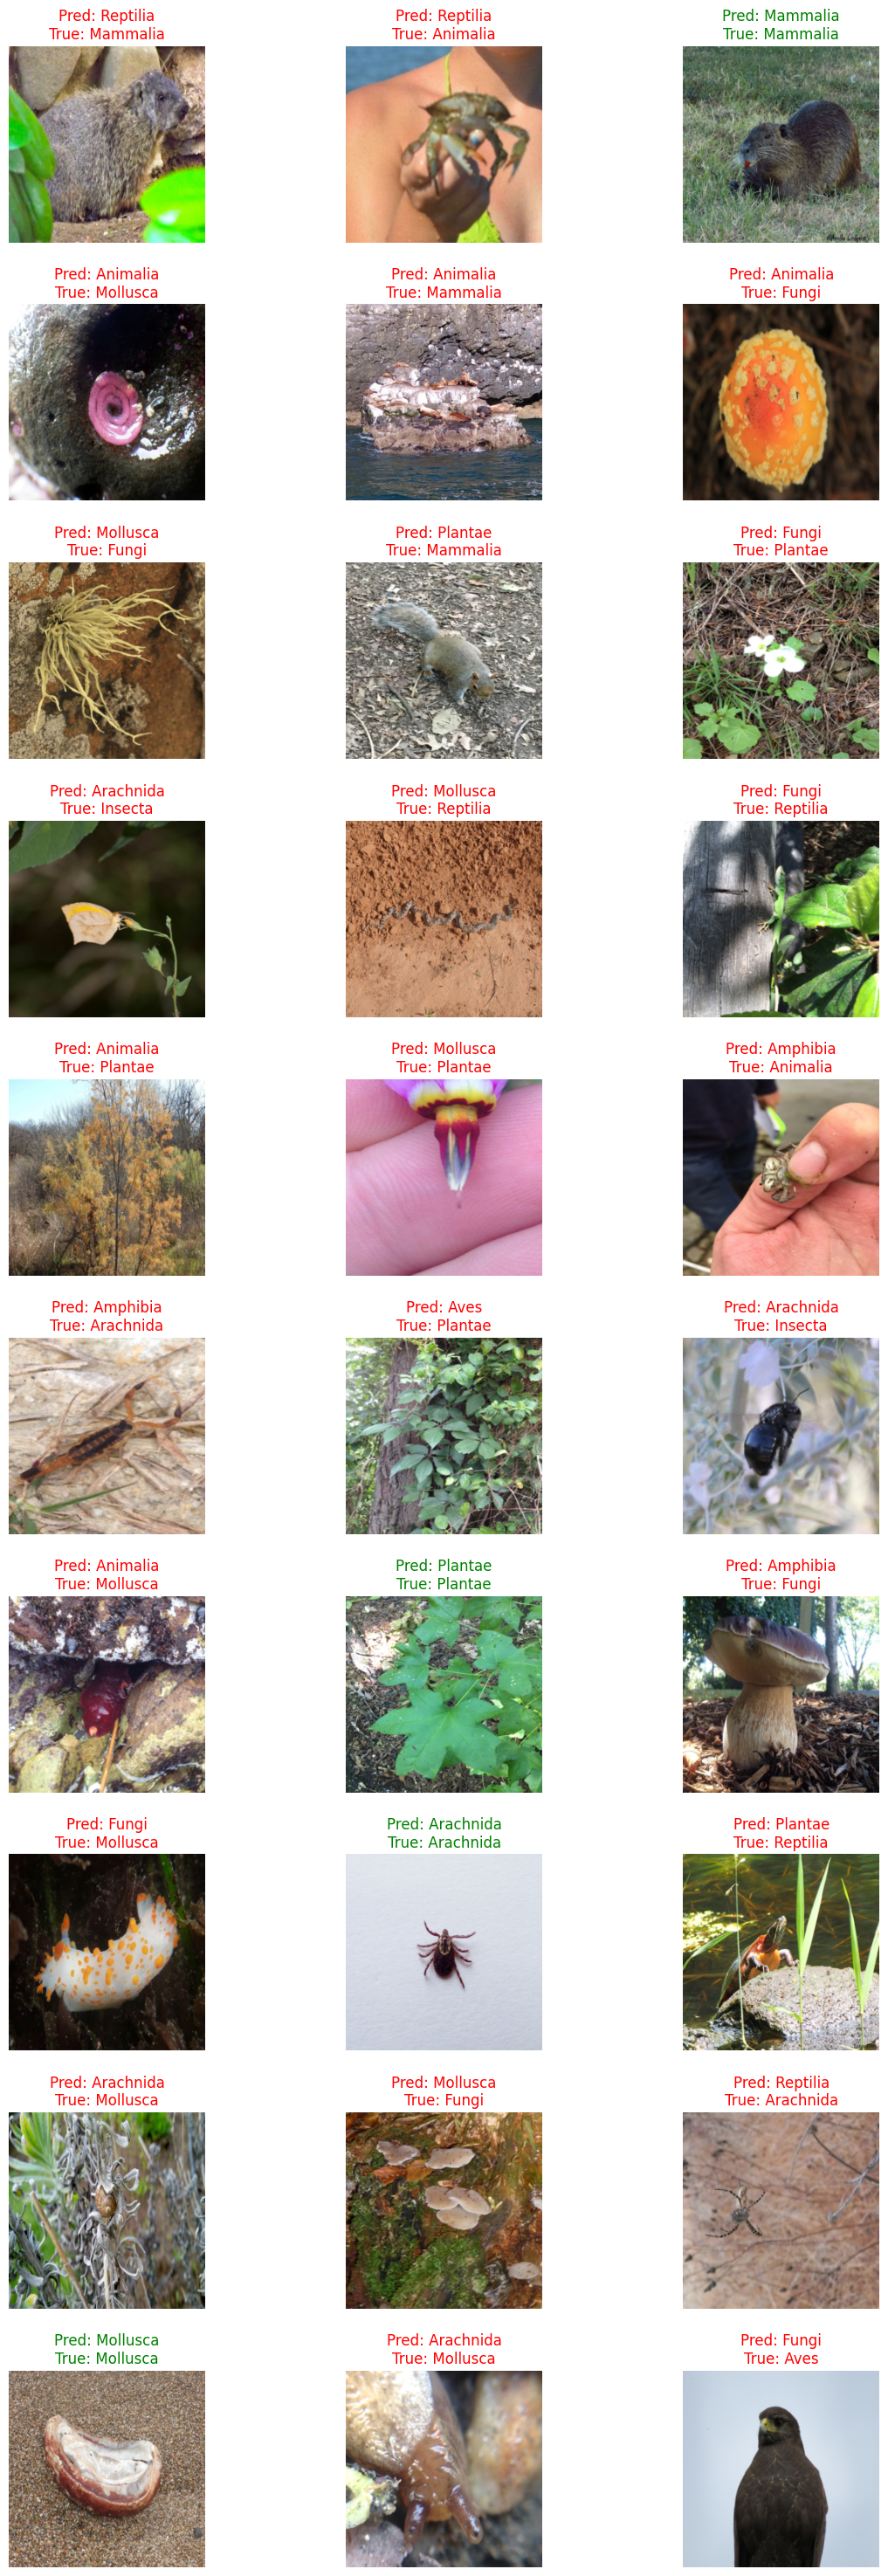

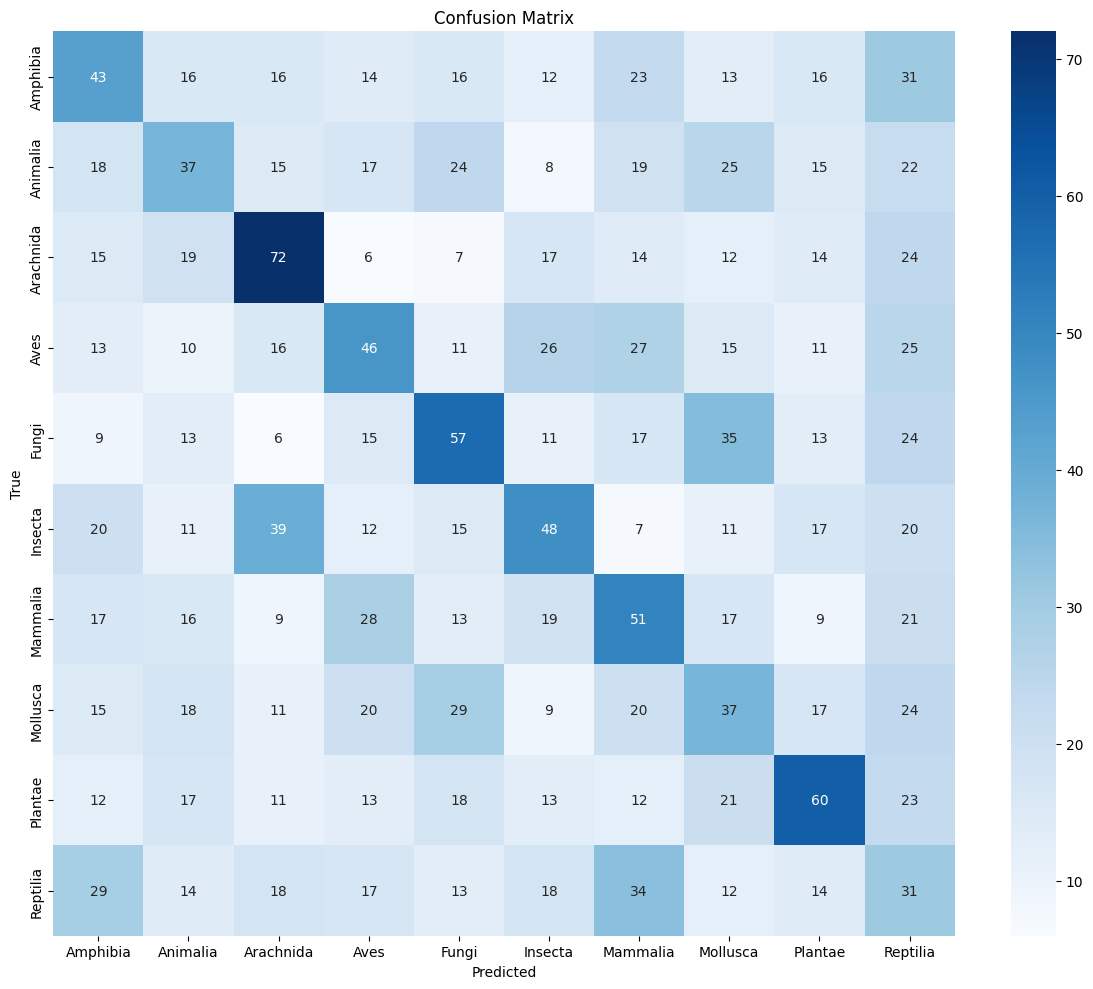

Model saved to best_model.pt


(CNNModel(
   (activation): GELU(approximate='none')
   (conv_blocks): ModuleList(
     (0): Sequential(
       (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (activation1): GELU(approximate='none')
       (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (dropout1): Dropout(p=0.2, inplace=False)
     )
     (1): Sequential(
       (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (activation2): GELU(approximate='none')
       (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
       (dropout2): Dropout(p=0.2, inplace=False)
     )
     (2): Sequential(
       (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [84]:
train_with_best_config()